In [265]:
import pandas as pd
import numpy as np
import seaborn as snb
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve,auc,recall_score,accuracy_score, f1_score, precision_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression,LinearRegression



from sklearn  import svm


def mapping(df,col_to_map,m=list(),verbose=False):
    v=df[col_to_map].value_counts().reset_index()
    if not m:
        v['map']=np.arange(v['index'].count())
    else:
        v['map']=m
    mymap={}

    for k,c in zip(v['index'],v['map']):
        mymap[k]=c
         
    if(verbose):
        print(mymap)
    return df[col_to_map].map(mymap)

def model_res(model, X_train,y_train,X_test,y_test,features_col):
    final={}
    try:
        final['kernel']=[model.kernel];
        final['gamma']=[model.gamma]
        final['C']=[model.C]
    except:
        final['kernel']=None;
        final['gamma']=None
        final['C']=None
    final['Score:Training']=[model.score(X_train,y_train)]
    final['Score:Test']=[model.score(X_test,y_test)]
    final['Recall:Test']=[recall_score(y_test,model.predict(X_test),average="macro")]
    final['Recall:Training']=[recall_score(y_train,model.predict(X_train),average="macro")]
    final['f1score_training']=[f1_score(y_train, model.predict(X_train), average="macro")]
    final['f1score_test']=[f1_score(y_test, model.predict(X_test), average="macro")]
    final['precision_test']=[precision_score(y_test, model.predict(X_test), average="macro")]
    final['precision_training']=[precision_score(y_train, model.predict(X_train), average="macro")]
     
    return final;

In [221]:
filename_training='Training_housing.csv'
filename_testing='Testing_housing.csv'

In [222]:
df=pd.read_csv(filename_training)
df.head()

,Id,MSSubClass,MSZoning,KitchenQual,BsmtFinType1,Foundation,HouseStyle,Neighborhood,Bathroom,LivingArea,...,HeatingQC,Electrical,YrSold,MoSold,SalePrice,BedroomAbvGr,SalePriceNorm,Heating,CentralAir,Pool
0,1,60,RL,Gd,GLQ,PConc,2Story,CollgCr,3.5,3371.0,...,Ex,SBrkr,2008,2,208500,3,12.247699,1,1,0
1,2,20,RL,TA,ALQ,CBlock,1Story,Veenker,2.5,3282.0,...,Ex,SBrkr,2007,5,181500,3,12.109016,1,1,0
2,3,60,RL,Gd,GLQ,PConc,2Story,CollgCr,3.5,3518.0,...,Ex,SBrkr,2008,9,223500,3,12.317171,1,1,0
3,4,70,RL,Gd,ALQ,BrkTil,2Story,Crawfor,2.0,3422.0,...,Gd,SBrkr,2006,2,140000,3,11.849405,1,1,0
4,5,60,RL,Gd,GLQ,PConc,2Story,NoRidge,3.5,4805.0,...,Ex,SBrkr,2008,12,250000,4,12.429220,1,1,0


In [223]:
test=pd.read_csv(filename_testing)



# Mapping Categorical variable

In [225]:
for c in df.select_dtypes(include='object').columns:
    name=c+'_map'
    df[name]=mapping(df,c)


In [224]:
for c in test.select_dtypes(include='object').columns:
    name=c+'_map'
    test[name]=mapping(test,c)

In [226]:
print(df.isnull().sum()[df.isnull().sum()>0])
print(test.isnull().sum()[test.isnull().sum()>0])

Series([], dtype: int64)
Series([], dtype: int64)


# Base Model: LivingArea

Here my hypothesis is that the size of the properties is a good predictor of the model. 

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


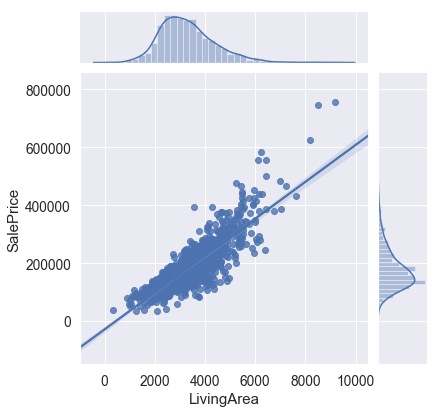

In [324]:
snb.jointplot('LivingArea','SalePrice',data=df,kind='reg')

# Base Model: Linear Regression

In [442]:
def linear_res(model,Xtrain,ytrain,Xtest,ytest,feature):
    final=pd.DataFrame()
    
    final['score test']=[mod.score(Xtest,ytest)]
    final['score train']=[mod.score(X,y)]
    final['r2_score']=[r2_score(ytest,mod.predict(Xtest))]
    final['#Features']=[len(feature)]
    final['feature']=[feature] 
    final['pred']=[mod.predict(Xtest)]
    final['mean_sq_errors']=mean_squared_error(ytest, mod.predict(Xtest))
    return final;

In [342]:
feature='LivingArea'
target='SalePriceNorm'
X=pd.DataFrame(df[feature])
Xtest=pd.DataFrame(test[feature])
y=df[target]
ytest=test[target]

mod=LinearRegression().fit(X,y)


Model=linear_res(mod,X,y,Xtest,ytest,feature)

# Adding extra features

I am using the correlation to select column to add to the model.

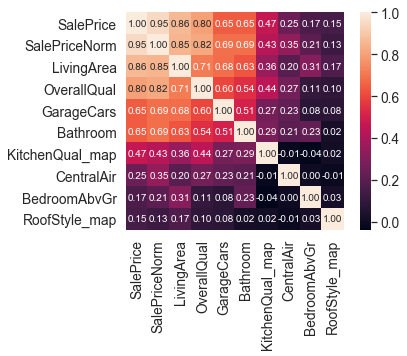

In [422]:
#Create the correlation matrix for all the column in the df
corrmat=df.corr()
# Top 10 Heatmap
k = 10 #number of variables for heatmap
#choose the first k column that correlate with 'Sale Price'
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
snb.set(font_scale=1.25)
hm = snb.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)


plt.savefig('image/Correlation10feature.png')

In [443]:
feature=[]
target='SalePriceNorm'
Model=pd.DataFrame()
for c in cols:
    if c != 'SalePrice' and c!='SalePriceNorm':
        feature.append(c)
        X=pd.DataFrame(df[feature])
        Xtest=pd.DataFrame(test[feature])
        y=df[target]
        ytest=test[target]
        mod=LinearRegression().fit(X,y)
        Model=Model.append(linear_res(mod,X,y,Xtest,ytest,feature))
        


In [448]:
Model.columns

Index(['score test', 'score train', 'r2_score', '#Features', 'feature', 'pred',
       'mean_sq_errors'],
      dtype='object')

# Making Plot for Presentation


In [438]:
import scipy.stats as stats
def joinplotfeaturevstarget(df,feature,target,kind='reg'):
    j=snb.jointplot(x=df[feature], y=df[target], kind=kind)
    j.annotate(stats.pearsonr)
    
def prediction_plot(ytrue,ypred):
    plt.scatter(ytrue,ypred)
    plt.plot([ytrue.min(),ytrue.max()],[ypred.min(),ypred.max()],'k')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


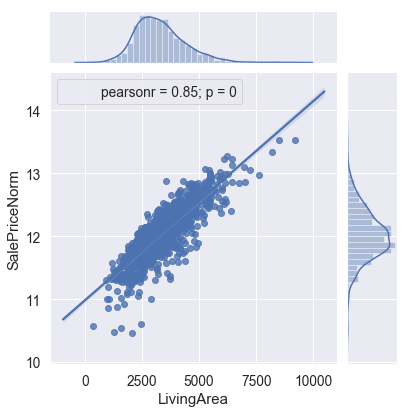

In [391]:
# BaseModel

joinplotfeaturevstarget(df,'LivingArea','SalePriceNorm',kind='reg')
plt.savefig('image/SalevsLivingArea.png')

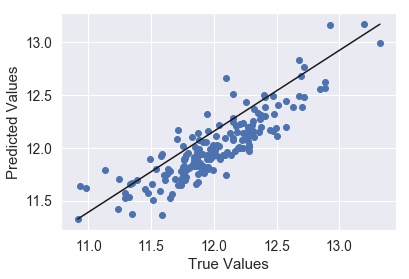

In [441]:
prediction_plot(ytest,Model['pred'].iloc[0])
plt.savefig('image/BaseModel.png')

In [449]:
Model[['score test','score train','r2_score','mean_sq_errors']].head(1)

,score test,score train,r2_score,mean_sq_errors
0,0.749545,0.728518,0.749545,0.041214


Plot diagonal correlation Matrix


In [421]:
snb.set(style="white")
#cm = np.corrcoef(df[cols].values.T)
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = snb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
snb.heatmap(cm, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
            yticklabels=cols.values, xticklabels=cols.values)


SyntaxError: keyword argument repeated (<ipython-input-421-10320c7b4b6a>, line 10)

In [461]:
def varvstarget(df,feature,target):
    print(target,feature)
    data = pd.concat([df[target], df[feature]], axis=1)
    f, ax = plt.subplots(figsize=(20, 8))
    fig = snb.boxplot(x=feature, y=target, data=data)
    fig.axis(ymin=0, ymax=800000);

In [450]:
Model[['score test','score train','r2_score','#Features','mean_sq_errors']]

,score test,score train,r2_score,#Features,mean_sq_errors
0,0.749545,0.728518,0.749545,1,0.041214
0,0.839009,0.821356,0.839009,2,0.026492
0,0.838195,0.827793,0.838195,3,0.026626
0,0.846125,0.845491,0.846125,4,0.025321
0,0.841438,0.847241,0.841438,5,0.026092
0,0.859046,0.860756,0.859046,6,0.023195
0,0.858892,0.860774,0.858892,7,0.023220
0,0.859309,0.861049,0.859309,8,0.023151


,score test,score train,r2_score,#Features,feature,pred
0,0.749545,0.728518,0.749545,1,"[LivingArea, OverallQual, GarageCars, Bathroom...","[11.825056447691248, 11.894080628406227, 11.81..."
0,0.839009,0.821356,0.839009,2,"[LivingArea, OverallQual, GarageCars, Bathroom...","[11.884601792833966, 11.803344485537947, 11.75..."
0,0.838195,0.827793,0.838195,3,"[LivingArea, OverallQual, GarageCars, Bathroom...","[11.912429520287837, 11.77404846567656, 11.787..."
0,0.846125,0.845491,0.846125,4,"[LivingArea, OverallQual, GarageCars, Bathroom...","[11.911353672893991, 11.78590299487069, 11.751..."
0,0.841438,0.847241,0.841438,5,"[LivingArea, OverallQual, GarageCars, Bathroom...","[11.89740511783928, 11.801499855125236, 11.768..."
0,0.859046,0.860756,0.859046,6,"[LivingArea, OverallQual, GarageCars, Bathroom...","[11.902383172192039, 11.83479935046352, 11.797..."
0,0.858892,0.860774,0.858892,7,"[LivingArea, OverallQual, GarageCars, Bathroom...","[11.900922070681782, 11.835130609865363, 11.79..."
0,0.859309,0.861049,0.859309,8,"[LivingArea, OverallQual, GarageCars, Bathroom...","[11.898442505854376, 11.83262761435247, 11.796..."


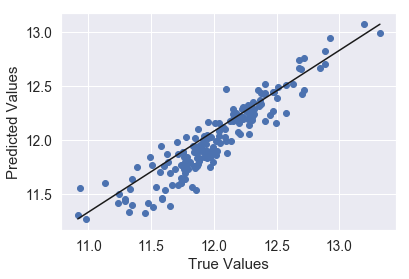

In [440]:
prediction_plot(ytest,Model['pred'].iloc[-1])
plt.savefig('image/BestModel.png')

SalePrice Renovation


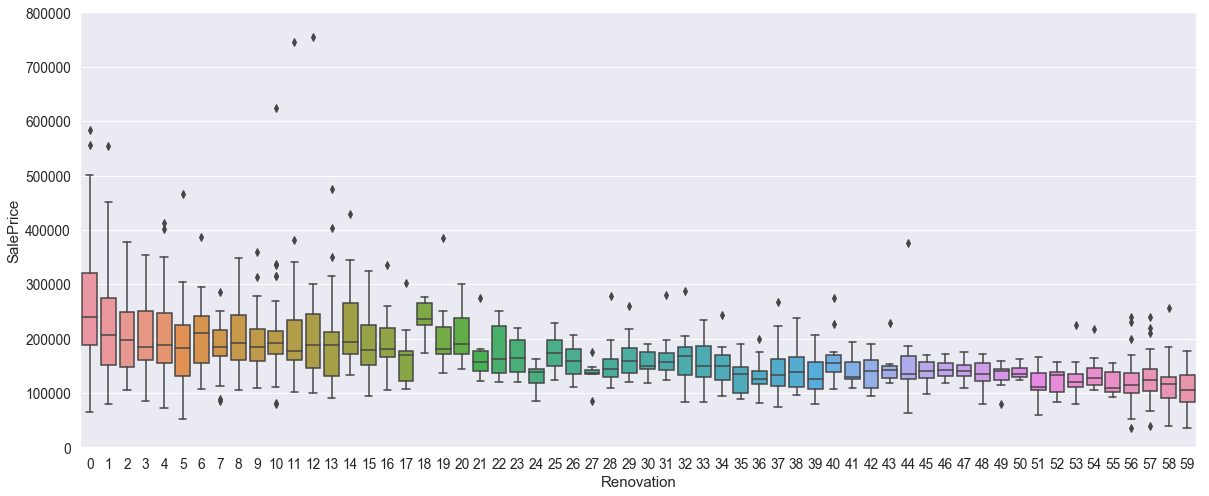

In [462]:
 
varvstarget(df,"Renovation",'SalePrice')
plt.savefig('image/Renovation.png')

In [453]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'KitchenQual', 'BsmtFinType1',
       'Foundation', 'HouseStyle', 'Neighborhood', 'Bathroom', 'LivingArea',
       'OverallQual', 'OverallCond', 'Renovation', 'GarageCars',
       'Foundation.1', 'RoofStyle', 'BldgType', 'HeatingQC', 'Electrical',
       'YrSold', 'MoSold', 'SalePrice', 'BedroomAbvGr', 'SalePriceNorm',
       'Heating', 'CentralAir', 'Pool', 'MSZoning_map', 'KitchenQual_map',
       'BsmtFinType1_map', 'Foundation_map', 'HouseStyle_map',
       'Neighborhood_map', 'Foundation.1_map', 'RoofStyle_map', 'BldgType_map',
       'HeatingQC_map', 'Electrical_map'],
      dtype='object')

SalePrice Neighborhood_map


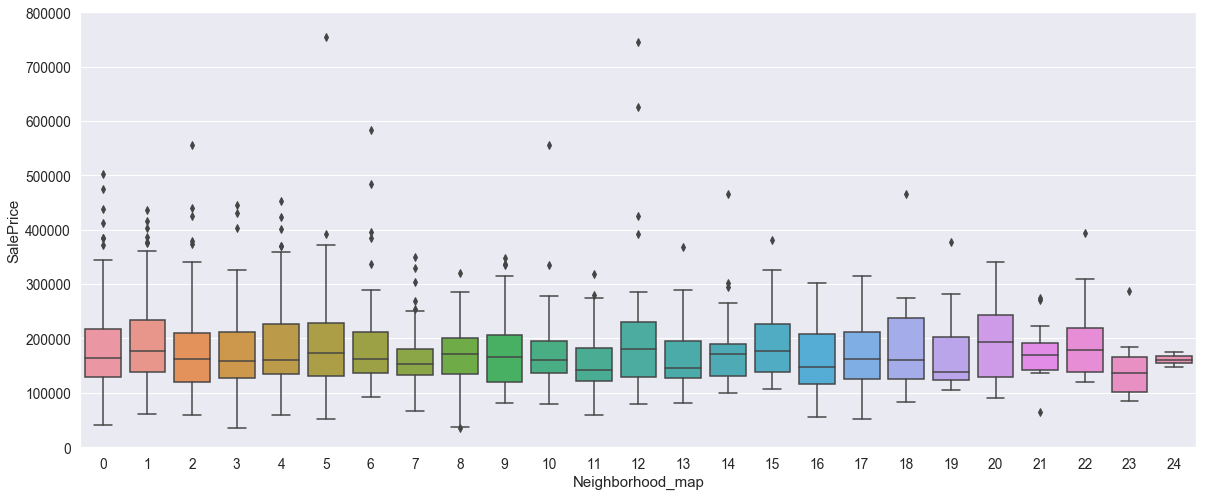

In [468]:
df['Neighborhood_map']=np.sort(df['Neighborhood_map'])
varvstarget(df,'Neighborhood_map','SalePrice')
plt.savefig('image/Neighborhood.png')

SalePrice MSZoning


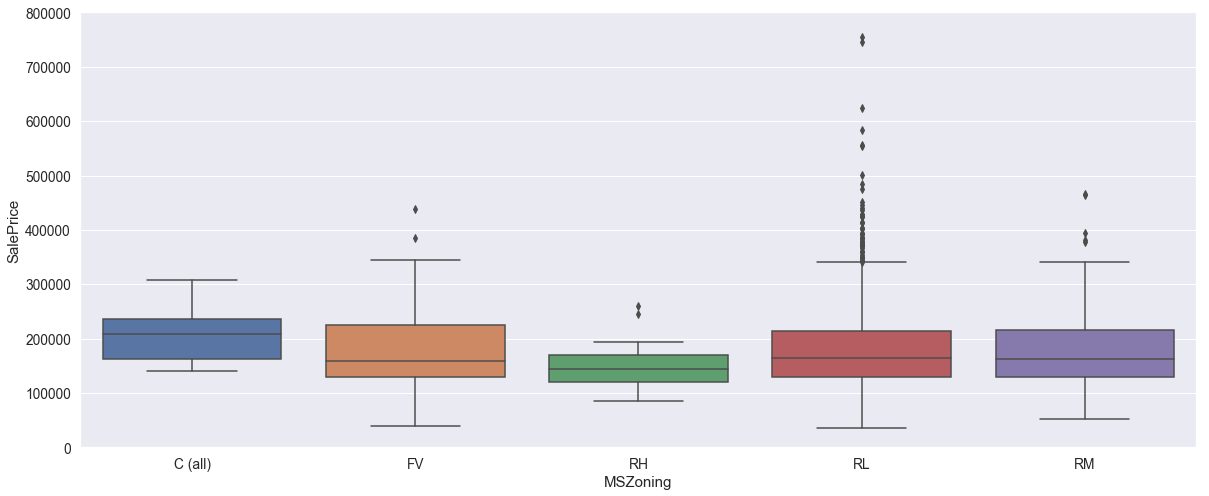

In [471]:
df['MSZoning']=np.sort(df['MSZoning']) 
varvstarget(df,'MSZoning','SalePrice')
plt.savefig('image/Zoning.png')